In [63]:
## April 10 2017
## Judy Fan (jefan@) and Jordan Gunn (jgunn@)
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

## NOTE: On the 'sketchloop' machine, data are found in sketchloop02 directory at the same level as this 'neurosketch' 
## analysis directory, and are organized by subject. All the paths here are defined for the file organization on this 
## computer, so this code won't run as-is 

import warnings
warnings.filterwarnings('ignore')

In [64]:
import numpy as np
import glob
import os
import scipy.stats as stats
from sklearn import metrics
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import seaborn as sns

import brainiak
import nibabel
import nilearn
from nilearn import image

from sklearn.metrics.pairwise import pairwise_distances as pd
from sklearn import svm
import sklearn
import analysis_helpers as helpers
import _pickle as cPickle

## Setup

In [65]:
# load in experimental design pickle file
# ??? What's a pickle file? How does this represent experimental design?
with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 
    

In [66]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

In [67]:
# behavioral data from database
import json
with open('versionNums.json') as json_data:
    coll = json.load(json_data)

In [68]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02/'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
33 subjects


In [83]:
## Analysis helper functions (see and update: analysis_helpers.py)

def get_object_index(morphline,morphnum):
    # **this is unused in the code**
    # get numbers that correspond to each object in the 
    # list of furniture items 
    furniture_axes = ['bedChair', 'bedTable', 'benchBed', 
                      'chairBench', 'chairTable', 'tableBench']
    car_axes = ['limoToSUV','limoToSedan','limoToSmart',
                'smartToSedan','suvToSedan','suvToSmart']  
    furniture_items = ['bed','bench','chair','table']
    car_items = ['limo','sedan','smartcar','SUV']               
    endpoints = mdr_helpers.getEndpoints(morphline)
    morphnum = float(morphnum)
    whichEndpoint = int(np.round(morphnum/100))
    thing = endpoints[whichEndpoint]
    if morphline in furniture_axes:
        return furniture_items.index(thing)+1
    elif morphline in car_axes:
        return car_items.index(thing)+1    
    
def getEndpoints(morphline):
    # return two components 
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']          

    
def triple_sum(X):
    # take triple sum of variable
    return sum(sum(sum(X)))

def get_mask_array(mask_path):
    # loads mask applied to nifty (.nii.gz) file
    # mask selects voxels to be included/discarded
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels
    
def load_roi_mask(subj,run_num,roi):
    # some masks already generated from anatomical atlas; 
    mask_path = proj_dir + subj +'/analysis/firstlevel/rois/' + roi + '_func_run_' + str(run_num) + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_roi_mask_combined(subj,run_num,roi):
    if run_num in [1,2]:
        phase_num = '12' 
    elif run_num in [3,4]:
        phase_num = '34'
    elif run_num in [5,6]:
        phase_num = '56'
    mask_path = proj_dir + '/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_' + phase_num + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def normalize(X):
    mn = X.mean(0)
    sd = X.std(0)
    X = X - mn
    X = X / np.maximum(sd, 1e-5)
    return X

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = proj_dir + '/' + subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
                '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num):
    mask = load_roi_mask_combined(subj,run_num,roi)
    vol = load_single_run_weights(subj,run_num,cope_num)
    vec = apply_mask(vol,mask)
    return vec

def extract_obj_by_voxel_run_mat(this_sub,run_num, roi):
    cope1 = load_data_and_apply_mask(this_sub,run_num,roi,1)
    cope2 = load_data_and_apply_mask(this_sub,run_num,roi,2)
    cope3 = load_data_and_apply_mask(this_sub,run_num,roi,3)
    cope4 = load_data_and_apply_mask(this_sub,run_num,roi,4)
    return np.vstack((cope1,cope2,cope3,cope4))

def plot_phase_RSM(this_sub,roi,phase):
    '''
    e.g., plot_phase_RSM(this_sub,'fusiform','pre')
    '''
    if phase=='pre':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_obj_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_obj_by_voxel_run_mat(this_sub,6,roi)        
    stacked = np.vstack((mat1,mat2))
    plt.matshow(np.corrcoef(stacked))
    plt.colorbar()

    
def extract_condition_by_voxel_run_mat(this_sub,run_num, roi):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[0]])
    slot2 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[1]])
    slot3 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[2]])
    slot4 = load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[3]])
    return np.vstack((slot1,slot2,slot3,slot4))
    
    
def remove_nans(array):
    return array[~np.isnan(array)]

def rmse(a):
    return np.sqrt(np.mean(map(np.square,a)))

def betwitdist(a,b,ab):
    return ab/np.sqrt(0.5*(a**2+b**2))

def norm_hist(data,bins):
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data, bins=bins, weights=weights)
    
def compare_btw_wit_obj_similarity_across_runs(this_sub,phase,roi):
    if phase=='searchlight':
        sl_compare_btw_wit_obj_similarity_across_runs(this_sub, phase, mask)
    elif phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi)
    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = wit_obj.mean()
    btw_mean = btw_obj.mean()
    return wit_mean,btw_mean

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi):

    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean, conbtw_mean 

#### Get a sense for file hierarchy on sample subject and plot some things

In [70]:
## Get a sense for file hierarchy on sample subject
# do for single subject for now
this_sub = sub_dirs[0]

analysis1_path = os.path.join(proj_dir,this_sub,'analysis','firstlevel')
analysis1_dirs = os.listdir(analysis1_path)
if 'glm4_recognition_run_1+.feat' in analysis1_dirs:
    print('Check to make sure you get rid of redundant/incomplete GLM folders for this subject')
# print(sorted(analysis1_dirs))

## glm output directories by run number
pre1 = 'glm4_recognition_run_3.feat'
pre2 = 'glm4_recognition_run_4.feat'
post1 = 'glm4_recognition_run_5.feat'
post2 = 'glm4_recognition_run_6.feat'

stats_path = os.path.join(proj_dir,this_sub,'analysis','firstlevel',pre1,'stats')
contents_stats_dir = os.listdir(stats_path)
# print(sorted(contents_stats_dir))

## load ROI mask
rois_path = os.path.join(proj_dir,this_sub,'analysis','firstlevel','rois')
contents_rois = os.listdir(rois_path)
# print(sorted(contents_rois))

In [71]:
## Some test plots of cope maps on this sample subject
plot_test_flag = 0
if plot_test_flag:
    from nilearn import image
    from nilearn import plotting
    nifti_path = os.path.join(proj_dir,s,'analysis','firstlevel',post1,'stats','cope1.nii.gz')
    plotting.plot_glass_brain(nifti_path)

In [72]:
plot_test_flag = 0
if plot_test_flag:
    fmri_img = image.smooth_img(nifti_path,fwhm=3)
    from nilearn.plotting import plot_epi
    mean_img = image.mean_img(fmri_img)
    plot_epi(mean_img, title='Smoothed mean EPI', cut_coords=[-37,-25,-6])

## Similarity analysis

In [73]:
## DESIGN ## ## ## ## 
## There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
## Runs 1 & 2 -- reserved to conduct searchlight
## Runs 3 & 4 -- pretest phase 
## Four training runs involving practice drawing two of the trained objects. 
## Runs 5 & 6 -- posttest phase
## GOAL ## ## ## ## 
## Compare similarity between Trained object representations before and after training (vs. Control) in several
## anatomically-defined ROIs. To do this, define `representation' as cope maps generated 
## upon fitting GLM to each object for each run. Build object x voxel matrix (4xK) for each run, vertically concatenate
## the two runs in each phase, and compute correlation matrix. Consider M = off-diagonal 4x4 block [:4,4:8].
## Make sure the rows are sorted such that the first two are the Trained, and the last two are the Control objects.
## Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control.
## The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs.
## The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. 
## [_A_|_B_]
## [_C_|_D_]
## Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase. 
## Do the above for the pretest, then for the posttest, and compare.

In [77]:
## Example code block single subject and ROI (fusiform):
run_example = 0
if run_example:
    trawit_mean_pre,conwit_mean_pre,trabtw_mean_pre,conbtw_mean_pre = compare_btw_wit_cond_similarity_across_runs(this_sub,'pre','fusiform')
    trawit_mean_post,conwit_mean_post,trabtw_mean_post,conbtw_mean_post = compare_btw_wit_cond_similarity_across_runs(this_sub,'post','fusiform')

    tradiff_pre = trabtw_mean_pre - trawit_mean_pre
    condiff_pre = conbtw_mean_pre - conwit_mean_pre

    tradiff_post = trabtw_mean_post - trawit_mean_post
    condiff_post = conbtw_mean_post - conwit_mean_post

    print('Trained Btw-Wit Post-Pre: ' + str(tradiff_post-tradiff_pre))
    print('Control Btw-Wit Post-Pre: ' + str(condiff_post-condiff_pre))  

Trained Btw-Wit Post-Pre: 0.0149948891989
Control Btw-Wit Post-Pre: -0.00687911218069


In [75]:
### April 8 2017: Now compute for all subjects (N=33 at time of initial commit), and for 5 different anat-ROIs

Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []

ROIs = ['V1','fusiform','IT','LOC','occitemp']

for roi in ROIs:
    print(roi)    
    _Tradiffpre = []
    _Condiffpre = []
    _Tradiffpost = []
    _Condiffpost = []
        
    for s in sub_dirs:
#         print(s)
        trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
        compare_btw_wit_cond_similarity_across_runs(s,'pre',roi)
        trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
        compare_btw_wit_cond_similarity_across_runs(s,'post',roi)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)

        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)
        
    _Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))


V1
fusiform
IT
LOC
occitemp


In [48]:
## save out so you can import later and share
if shape(Tradiffpre)==(len(ROIs),len(sub_dirs)): ## ONLY save out if you've actually finished the analysis above
    with open("prepost_differentiation_by_condition.pkl", 'wb')  as _f:
        cPickle.dump([Tradiffpost,Tradiffpre,Condiffpost,Condiffpre], _f)

In [49]:
# print('Trained Btw-Wit Post-Pre: ' + str(Tradiffpost-Tradiffpre))
# print('Control Btw-Wit Post-Pre: ' + str(Condiffpost-Condiffpre))  

In [50]:
## load in saved pkl
with open('prepost_differentiation_by_condition.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1') 

### Sensitivity to measuring differences between object representations separately in each phase

In [51]:
## Make sure that the off-diagonal minus on-diagonal elements (btw-within) in each matrix > 0.
## this indicates that the correlation distance between different objects is larger than that between
## measurements of the same object. This needs to be the case for looking at learning to make sense. 


In [52]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

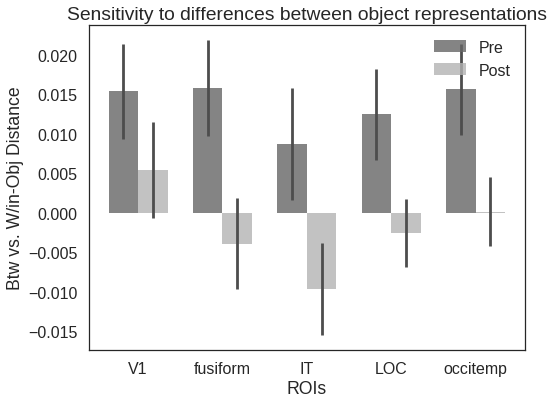

Saving figure to 'plots/object_discriminability_by_roi_group_mean.pdf'...
Done


In [53]:
sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(8,6))

n_groups = 5 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_roi_group_mean', ext='pdf', close=False, verbose=True)



### Learning-related changes in representational distance

In [54]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

In [55]:
ROIs = ['V1','fusiform','IT','LOC','occitemp']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

[ 0.0114137   0.01006371  0.00996037  0.00862908  0.00831173]
[-0.01017608 -0.01887716 -0.03111169 -0.02296502 -0.01881378]


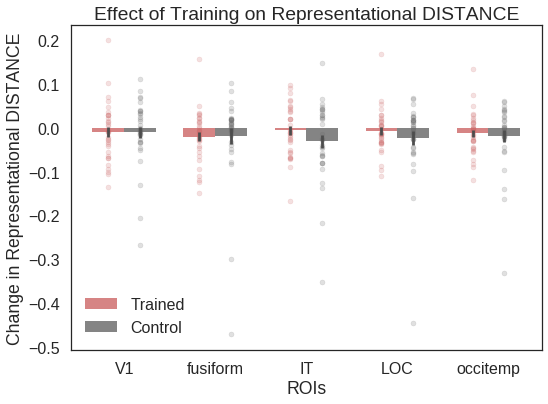

Saving figure to 'plots/differentiation_by_roi_indiv_sub.pdf'...
Done


In [56]:
## Generate summary plot (main analysis)

plot_indiv_subs = 1

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(8,6))

n_groups = 5 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)



In [84]:
###### Variant of analysis ***ignoring training condition***, and just looking at overall change in between vs. within 
###### object similarity.

run_this = 1
if run_this:
    Witpre = []
    Btwpre = []
    Witpost = []
    Btwpost = []
    Diffpre = []
    Diffpost = []

    ROIs = ['V1','fusiform','paraphippo','IT','LOC','occitemp']

    for roi in ROIs:
        print(roi)
        _Witpre = []
        _Btwpre = []
        _Witpost = []
        _Btwpost = []
        _Diffpre = []
        _Diffpost = []
        for s in sub_dirs:
            wit_pre,btw_pre = compare_btw_wit_obj_similarity_across_runs(s,'pre',roi)
            wit_post,btw_post = compare_btw_wit_obj_similarity_across_runs(s,'post',roi)
            _Diffpre.append(btw_pre-wit_pre)
            _Diffpost.append(btw_post-wit_post)    
            _Witpre.append(wit_pre)
            _Btwpre.append(btw_pre)
            _Witpost.append(wit_post)
            _Btwpost.append(btw_post)    

        _Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost = map(np.array,[_Witpre,_Btwpre,_Witpost,_Btwpost,_Diffpre,_Diffpost])

        if len(Witpre)==0:
            Witpre = _Witpre
            Btwpre = _Btwpre
            Witpost = _Witpost
            Btwpost = _Btwpost
            Diffpre = _Diffpre
            Diffpost = _Diffpost
        else:
            Witpre = np.vstack((Witpre,_Witpre))
            Btwpre = np.vstack((Btwpre,_Btwpre))   
            Witpost = np.vstack((Witpost,_Witpost))
            Btwpost = np.vstack((Btwpost,_Btwpost)) 
            Diffpre = np.vstack((Diffpre,_Diffpre))
            Diffpost = np.vstack((Diffpost,_Diffpost))         

V1
(2882,)
(2882,)
(2760,)
(2760,)
(2524,)
(2524,)
(2407,)
(2407,)
(3277,)
(3277,)
(3219,)
(3219,)
(3489,)
(3489,)
(3343,)
(3343,)
(2379,)
(2379,)
(2409,)
(2409,)
(3024,)
(3024,)
(2987,)
(2987,)
(2590,)
(2590,)
(2625,)
(2625,)
(2604,)
(2604,)
(2655,)
(2655,)
(2834,)
(2834,)
(2848,)
(2848,)
(3227,)
(3227,)
(3275,)
(3275,)
(2550,)
(2550,)
(3058,)
(3058,)
(2829,)
(2829,)
(2738,)
(2738,)
(2826,)
(2826,)
(2771,)
(2771,)
(2962,)
(2962,)
(2987,)
(2987,)
(2564,)
(2564,)
(2614,)
(2614,)
(2807,)
(2807,)
(2876,)
(2876,)
(2812,)
(2812,)
(2860,)
(2860,)
(3025,)
(3025,)
(3112,)
(3112,)
(2649,)
(2649,)
(2528,)
(2528,)
(2579,)
(2579,)
(2593,)
(2593,)
(2763,)
(2763,)
(2758,)
(2758,)
(2527,)
(2527,)
(2529,)
(2529,)
(2658,)
(2658,)


KeyboardInterrupt: 

## Searchlight Analysis

In [15]:
# searchlight code
def load_data_and_apply_mask(subj,run_num,roi,cope_num):
    mask = roi
    vol = load_single_run_weights(subj,run_num,cope_num)
    vec = apply_mask(vol,mask)
    return vec

def sl_extract_condition_by_voxel_run_mat(this_sub,run_num, roi):
    w = this_sub
    these = coll.find({'wID': w}).sort('trialNum')   
    versionNum = these[0]['versionNum']

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = sl_load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[0]])
    slot2 = sl_load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[1]])
    slot3 = sl_load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[2]])
    slot4 = sl_load_data_and_apply_mask(this_sub,run_num,roi,obj2cope[condorder[3]])
    return np.vstack((slot1,slot2,slot3,slot4))

def sl_compare_btw_wit_obj_similarity_across_runs(this_sub,phase,roi):
    if phase=='searchlight':
        mat1 = sl_extract_condition_by_voxel_run_mat(this_sub,1,roi)
        mat2 = sl_extract_condition_by_voxel_run_mat(this_sub,2,roi)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    DAB = sklearn.metrics.pairwise.pairwise_distances(fAB, metric='correlation') # square matrix, where off-diagblock is distances *between* fA and fB vectors
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]
    wit_obj = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])].diagonal()
    btw_obj = np.hstack((offblock[np.triu_indices(shape(offblock)[0],k=1)],offblock[np.tril_indices(shape(offblock)[0],k=-1)]))
    wit_mean = wit_obj.mean()
    btw_mean = btw_obj.mean()
    return wit_mean,btw_mean

def generate_mask_from_center(center, radius):
    # generate sphere by first creating a bounding box array, 
    # setting points of the sphere within it to 1
    mask = np.zeros((94, 94, 72))
    cx = center[0]
    cy = center[1]
    cz = center[2]
    r2 = np.arange(-radius, radius+1)**2
    dist2 = r2[:, None, None] + r2[:, None] + r2
    cube = (dist2 <= radius**2).astype(np.int)

    # then "center" this box within the mask
    for i in range(cx-radius, cx+radius):
        for j in range(cy-radius, cy+radius):
            for k in range(cz-radius, cz+radius):
                try: 
                    mask[i,j,k] = (
                        cube[i-(cx-radius), j-(cy-radius), k-(cz-radius)])
                except IndexError:
                    pass
    return mask

# (dimensions are 94 x 94 x 72)
dimensionX = 94
dimensionY = 94
dimensionZ = 72
radius = 3

# scan through each subject
for s in [sub_dirs[0]]:
    wit_means = np.zeros((94, 94, 72))
    byw_means = np.zeros((94, 94, 72))
    
    # scan through every voxel (dimensions are 94 x 94 x 72)
    for x in range(dimensionX):
        for y in range(dimensionY):
            for z in range (dimensionZ):
                # generate a searchlight mask (sphere centered on voxel)
                mask = generate_mask_from_center((x, y, z), radius)
                
                # pass subject, mask through comparison function
                # store wit_mean and btw_mean for said voxel
                wit_means[x][y][z], btw_means[x][y][z] = (
                    sl_compare_btw_wit_obj_similarity_across_runs(
                        s, 'searchlight', mask))
                print('something')
                
    # with every voxel processed, 
    # i have a map of the function's output
    # for every voxel-centered sphere
    
    # make a difference map
    difference = np.subtract(wit_means, btw_means)
    
    # produce a histogram of the difference distribution
    hist, bin_edges = np.histogram(np.reshape(difference, difference.size))
    plt.hist(hist, bins='auto')
    plt.title("Difference Distribution")
    plt.show()

ServerSelectionTimeoutError: localhost:20809: [Errno 111] Connection refused